In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [17]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))])
trainset =  datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Explanation of Preprocessing: The specific normalization here allows for MNIST pixel values to be mapped from [-1, 1], so that the networks can have better training results and scaling in the inputs. .ToTensor converts the transform to a python tensor. And batching and shuffling through the data loader

In [18]:
#shape of the train/test data
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [19]:
print("the size of the trainset is {}".format(len(trainset)))
print("the size of the testset is {}".format(len(testset)))

the size of the trainset is 60000
the size of the testset is 10000


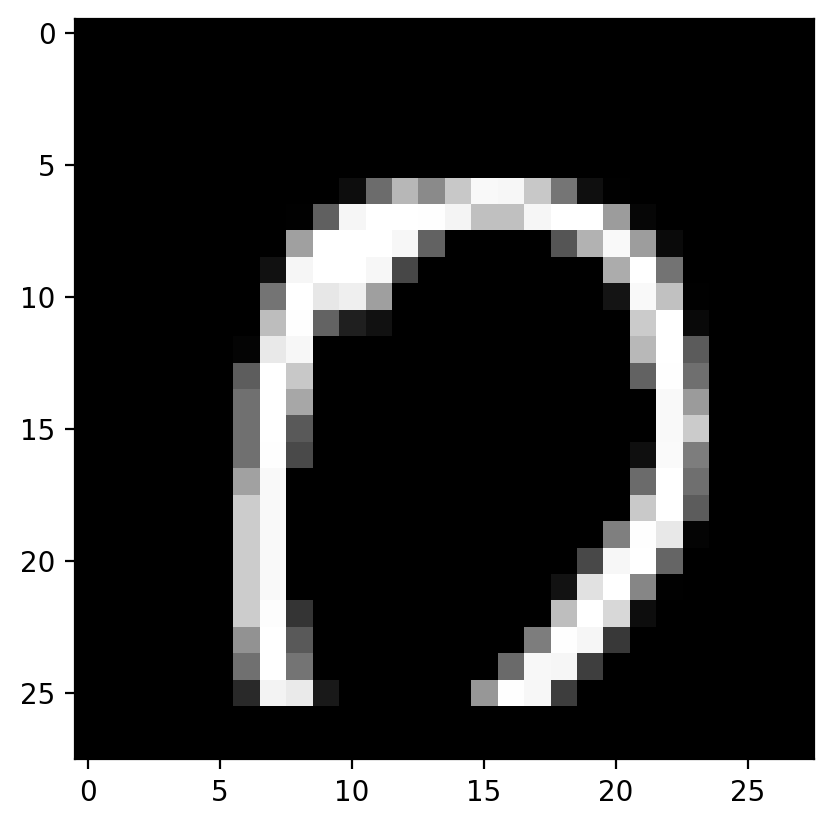

In [20]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()


optimizer = optim.SGD(model.parameters(), lr=0.003)

Training + testing below

In [23]:
epochs=5
train_losses, test_losses = [], []
for e in range(epochs):
    total_train_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    else:
        total_test_loss = 0
        test_correct = 0  # Number of correct predictions on the test set
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                images = images.view(images.shape[0], -1)
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                total_test_loss += loss.item()

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        # Get mean loss to enable comparison between train and test sets
        train_loss = total_train_loss / len(trainloader.dataset)
        test_loss = total_test_loss / len(testloader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

Epoch: 1/5..  Training Loss: 0.007..  Test Loss: 0.006..  Test Accuracy: 0.884
Epoch: 2/5..  Training Loss: 0.006..  Test Loss: 0.006..  Test Accuracy: 0.891
Epoch: 3/5..  Training Loss: 0.006..  Test Loss: 0.006..  Test Accuracy: 0.895
Epoch: 4/5..  Training Loss: 0.006..  Test Loss: 0.005..  Test Accuracy: 0.896
Epoch: 5/5..  Training Loss: 0.006..  Test Loss: 0.005..  Test Accuracy: 0.900


Doing a final test below

In [24]:
test_loss = 0
test_accuracy = 0

model.eval()


with torch.no_grad():
    for images, labels in testloader:  
        images, labels = images.to(device), labels.to(device)
        
        images = images.view(images.shape[0], -1)
        logps = model(images)
        
        test_loss += criterion(logps, labels).item()
        
        ps = torch.exp(logps)
       
        top_p, top_class = ps.topk(1, dim=1)
        
        equals = top_class == labels.view(*top_class.shape)
        
        test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

# Calculate average test loss and accuracy
test_loss /= len(testloader)
test_accuracy /= len(testloader)

# Print final results
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

Test Loss: 0.287
Test Accuracy: 0.916


In [25]:
torch.save(model.state_dict(), 'checkpoint_new.pth')

The following is redoing the testing, but with the following changes:
* epochs = 10
* dropout of 0.25
so a new model is being created with differing hyperparameters

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
model_2 = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Dropout(0.25),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()


optimizer = optim.SGD(model_2.parameters(), lr=0.003)

Training + testing

In [28]:
epochs = 10
train_losses, test_losses = [], []
for e in range(epochs):
    total_train_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        log_ps = model_2(images)
        loss = criterion(log_ps, labels)
        total_train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    else:
        total_test_loss = 0
        test_correct = 0  
        
       
        with torch.no_grad():
            for images, labels in testloader:
                images = images.view(images.shape[0], -1)
                log_ps = model_2(images)
                loss = criterion(log_ps, labels)
                total_test_loss += loss.item()

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        # Get mean loss to enable comparison between train and test sets
        train_loss = total_train_loss / len(trainloader.dataset)
        test_loss = total_test_loss / len(testloader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

Epoch: 1/10..  Training Loss: 0.006..  Test Loss: 0.005..  Test Accuracy: 0.902
Epoch: 2/10..  Training Loss: 0.005..  Test Loss: 0.005..  Test Accuracy: 0.906
Epoch: 3/10..  Training Loss: 0.005..  Test Loss: 0.005..  Test Accuracy: 0.906
Epoch: 4/10..  Training Loss: 0.005..  Test Loss: 0.005..  Test Accuracy: 0.907
Epoch: 5/10..  Training Loss: 0.005..  Test Loss: 0.005..  Test Accuracy: 0.910
Epoch: 6/10..  Training Loss: 0.005..  Test Loss: 0.005..  Test Accuracy: 0.914
Epoch: 7/10..  Training Loss: 0.005..  Test Loss: 0.004..  Test Accuracy: 0.918
Epoch: 8/10..  Training Loss: 0.005..  Test Loss: 0.004..  Test Accuracy: 0.917
Epoch: 9/10..  Training Loss: 0.004..  Test Loss: 0.004..  Test Accuracy: 0.919
Epoch: 10/10..  Training Loss: 0.004..  Test Loss: 0.004..  Test Accuracy: 0.919


Final Test

In [10]:
test_loss = 0
test_accuracy = 0


model_2.eval()


with torch.no_grad():
    for images, labels in testloader:  
        images, labels = images.to(device), labels.to(device)
        
        images = images.view(images.shape[0], -1)
        logps = model_2(images)
        
        test_loss += criterion(logps, labels).item()
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()


test_loss /= len(testloader)
test_accuracy /= len(testloader)

# Print final results
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

Test Loss: 0.223
Test Accuracy: 0.934


In [11]:
torch.save(model_2.state_dict(), 'checkpoint_hypo.pth')

Using the new model to look at one of the numbers being classified (below)

In [12]:
def classify(img, ps):
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()




Demonstrating how it works below

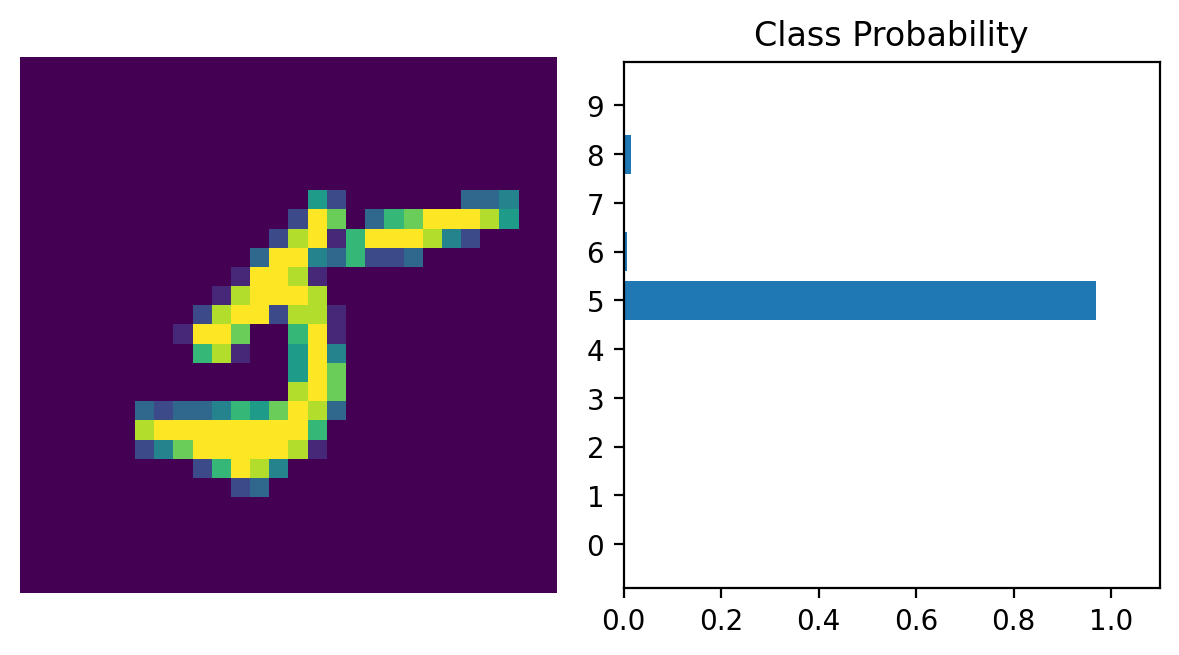

In [14]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)

with torch.no_grad():
    logps = model_2(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
classify(img.view(1, 28, 28), ps)